# GRIPA vs COVID

Polje z importi

In [1]:
import matplotlib
from math import isnan
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.stats import multivariate_normal as mvn
import scipy.cluster.hierarchy as sch
import pandas as pandas
import os
import sys
import json
import numpy as np
import math
import random
import matplotlib.pyplot as pltnk

# Priprava podatkov

In [2]:

"""warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')"""
%matplotlib inline

def read_csv():
    reader = pd.read_csv(r"..\podatki\US_gripa.csv")
    virus_array = reader.get_values()    #create array of data
    reader.head()
    Geop = reader["geoid"]
    Regija = reader["Region"]
    State = reader["State"]
    season = reader["season"]
    smr_g = reader["Deaths from influenza"]
    smr_pl = reader["Deaths from pneumonia"]
    smr_gp = reader["Pecent of deaths due to pneumonia or influenza"]
    smr_t = reader["All Deaths"]
    return smr_t,smr_gp,smr_pl,smr_g,season,State
    
def read_population_by_spol():
    rows_to_skip = [i for i in range(0, 16)]  
    rows_to_skip.extend([i for i in range(17, 272)])   # odstranjevanje vrstic ki bi delale probleme
    rows_to_skip.extend([i for i in range(362, 377)])
    names  =["Region-Country", "Date", "0-4", "5-9",  "10-14", "15-19", "20-24", "25-29", 
             "30-34", "35-39", "40-44", "45-49", "50-54", "55-59",  "60-64", "65-69", "70-74", "75-79",
             "80-84", "85-89", "90-94", "95-99", "100+"]

    main_set = pandas.read_excel('../podatki/POPULATION_BY_AGE_BOTH_SEXES.xlsx', 
                                 usecols=(2, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28),
                                    skiprows=rows_to_skip,
                                    names=names)
    main_set["population_sum"] = np.NaN
    main_set["avg_age"] = np.NaN

    for index, row in main_set.iterrows():
        temp_sum = 0
        for num_range, num in row[2:-2].iteritems():
            temp_sum += num

        main_set.loc[index,"population_sum"] = float(temp_sum)

        pop_age = 0        # mogoče zamenji z mediano 
        age_range = 2
        for num_range, num in row[2:-2].iteritems():
            pop_age += (num / temp_sum) * age_range
            age_range += 5
        main_set.loc[index,"avg_age"] = float(pop_age)
    return main_set
def matricaRead():
    matrica = []
    america = []
    with open('../podatki/corona_latest.csv', newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in spamreader:
                matrica.append(row)
                if row[-5] == 'United_States_of_America':
                    america.append(row)
    return matrica,america
def PripravaZaGripo(season,smr_g,smr_pl):
    dfg = defaultdict(list)
    dfp = defaultdict(list)
    leta = set()
    for y,sg,sp in zip(season,smr_g,smr_pl):
        if not isnan(sg) and not isnan(sp):
            dfg[y].append(float(sg))
            dfp[y].append(float(sp))
            leta.add(y)
    leta = list(leta)
    return leta,dfg,dfp
def PripravaZaClusteing(main_set):
    sez = np.array(main_set)
    nmatrix = []
    labels = []
    brez = ["NORTHERN AMERICA","Western Europe","Southern Europe","Russian Federation","Eastern Europe","EUROPE","EUROPE AND NORTHERN AMERICA","OCEANIA (EXCLUDING AUSTRALIA AND NEW ZEALAND)","AUSTRALIA/NEW ZEALAND","Central America","LATIN AMERICA AND THE CARIBBEAN","Lao People's Democratic Republic","South-Eastern Asia","Eastern Asia","EASTERN AND SOUTH-EASTERN ASIA","CENTRAL AND SOUTHERN ASIA","Western Sahara",
    "Northern Africa","NORTHERN AFRICA AND WESTERN ASIA","Western Africa","Southern Africa","Sao Tome and Principe","Central African Republic","Middle Africa","Eastern Africa","SUB-SAHARAN AFRICA","Oceania","Northern America","Latin America and the Caribbean","Europe","Asia","Africa"]
    ali = ["Slovenia","Italy","Sweden","United Kingdom","Serbia","Spain","France","Germany"]
    for x in sez:
        if x[0] not in brez and int(x[1])==2020:
                kolk = [int(str(i).replace(".","")) for i in x[2:-2]]
                suma = sum(kolk)
                nmatrix.append([k/suma for k in kolk]) 
                labels.append(x[0]+"/"+str(x[1]))
    return nmatrix,labels
def PripravaSmrtnosti(matrica):
    prvad = "Afghanistan"
    smrtnost =  defaultdict(float)
    smrtinapreb = defaultdict(float)
    death = 0
    case = 0
    folk = 0
    TOTAL_D = 0
    TOTAL_C = 0
    matrica = matrica[1:]
    for x in matrica:
        if(x[6]==prvad):
            TOTAL_D += int(x[5]) 
            TOTAL_C += int(x[4])
            death += int(x[5])
            case += int(x[4])
        if x[-2] != "" and x[6]==prvad:
            folk = int(x[-2])
        if x[6]!=prvad:
            smrtnost[prvad] = death/case*100
            if folk != 0:
                smrtinapreb[prvad] = death/folk     
            folk = 0
            prvad = x[6]
            death = int(x[5])
            case = int(x[4])
    smt = smrtnost
    return TOTAL_D,TOTAL_C,smrtinapreb,smrtnost

def PripravaParamSmrt(smrtnost):
    ignore = ["United_Republic_of_Tanzania","Saint_Vincent_and_the_Grenadines","Western_Sahara","Uzbekistan","United_States_Virgin_Islands","United_Republic_of_Tanzania","Turks_and_Caicos_islands","Taiwan","Tajikistan","Thailand","Timor_Leste","Togo","Sri_Lanka",
              "Sudan","Suriname","South_Sudan","Somalia","Sint_Maarten","Seychelles","Sao_Tome_and_Principe","Saint_Kitts_and_Nevis","Saint_Lucia","Saint_Vincent_and_the_Grenadines","Peru","Philippines","Papua_New_Guinea","Palestine",
    "Panama","Oman","Northern_Mariana_Islands","Nicaragua","Niger","Mozambique","Myanmar","Namibia","Nepal","Mongolia","New_Caledonia","Mauritania",
    "Mauritius","Malta","Madagascar","Malawi","Malaysia","Maldives","Liechtenstein","Lithuania","Luxembourg","Kyrgyzstan","Jersey","Jamaica","Isle_of_Man","Indonesia","Guinea_Bissau","Guyana","Haiti","Holy_See","Guatemala",
    "Guernsey","Grenada","Guam","Gambia","French_Polynesia","Falkland_Islands_(Malvinas)","Faroe_Islands","Bahamas","Anguilla","Eswatini","El_Salvador","Antigua_and_Barbuda",
    "Aruba","Equatorial_Guinea","Eritrea","Belize","Benin","Bangladesh","Barbados","Djibouti","Dominica","Comoros","Chad","Cape_Verde",
    "Cases_on_an_international_conveyance_Japan","Bonaire, Saint Eustatius and Saba","Bermuda","Bhutan","Cayman_Islands",
    "Central_African_Republic","Burkina_Faso","Burundi","Cambodia","British_Virgin_Islands","Brunei_Darussalam","Botswana","Lesotho"]
    smrtnosti = []
    smnapreb = []
    drzave = []
    for drz,dm in smrtnost.items():
        if drz not in ignore:
            smrtnosti.append(dm)
            smnapreb.append(dm)
            drzave.append(drz)
    return smrtnosti,smnapreb,drzave

def PripravaLetaDGP(dfg,dfp,leta):
    leta.sort()
    #trois seznames
    dg = []
    dp = []
    for x in leta:
        dg.append(sum(dfg[x]))
        dp.append(sum(dfp[x]))
    return dg,dp,leta


In [3]:
main_set = read_population_by_spol()
matrica,america = matricaRead()
matrica = np.array(matrica)
matrica[0]

NameError: name 'csv' is not defined

# GRIPA

#Grafi po letih

In [223]:
# Fixing random state for reproducibility
def years(leta, dg):
    y_pos = np.arange(len(leta))
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, dg, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(leta)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Smrti')
    ax.set_title('Smrti zaradi gripe')
    plt.show()

# Smrti zaradi gripe v ZDA za pretekla leta

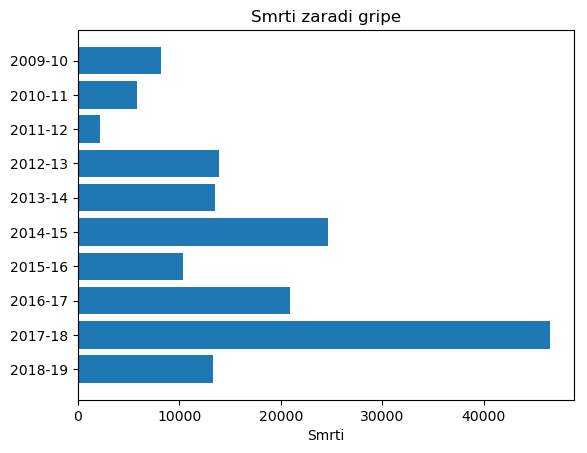

In [196]:
smr_t,smr_gp,smr_pl,smr_g,season,State = read_csv()
leta,dfg,dfp = PripravaZaGripo(season,smr_g,smr_pl)
dg,dp,leta = PripravaLetaDGP(dfg,dfp,leta)
years(leta, dg)

In [197]:
# Fixing random state for reproducibility
def plucnca(leta,dp):
    y_pos = np.arange(len(leta))

    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, dp, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(leta)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Smrti')
    ax.set_title('Smrti zaradi pljucnice')
    plt.show()


# Smrti zaradi pljučnice v ZDA za pretekla leta

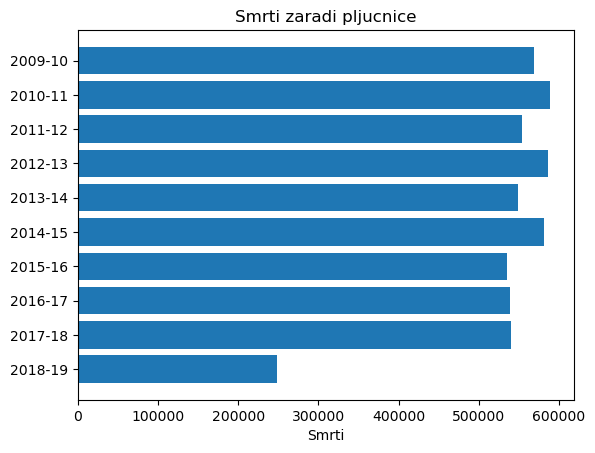

In [198]:
smr_t,smr_gp,smr_pl,smr_g,season,State = read_csv()
leta,dfg,dfp = PripravaZaGripo(season,smr_g,smr_pl)
dg,dp,leta = PripravaLetaDGP(dfg,dfp,leta)
plucnca(leta,dp)

OPAZANJE: Podatek za obdobje 2018_19 bi utegnil biti ne- veljaven saj vsepovsod velja, da imajo vzorci približno enako število primerov pri 2018-19 jih je le polovico(MERITVE SO NASTALE PO OBMOCJIH!NI OCITNO ZA VSA OBMOCJA)!

#Smrti po tednih in districtih

In [199]:
def PljuvnivaSmrtiDrzava(State,smr_gp,smr_t):
    total = defaultdict(int)
    pneum = defaultdict(int)
    stejt = []
    for kraj,grip,vsi in zip(State,smr_gp,smr_t):
        if not isnan(grip) and not isnan(vsi):
            stejt.append(kraj)
            total[kraj] += int(grip)
            pneum[kraj] += int(vsi)
    stejt  = list(set(stejt))
    grp = []
    vs = []
    for x in stejt:
        grp.append(total[x])
        vs.append(pneum[x])
    return grp,stejt,vs

def smrtiZaradiP(stejt,grp):
    y_pos = np.arange(len(stejt))
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(20,20))
    matplotlib.rc('xtick', labelsize=0.2) 
    ax.figsize=(35, 35)
    ax.barh(y_pos, grp, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(stejt)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Smrti')
    ax.set_title('Smrti zaradi pljucnice')
      # labels read top-to-bottom
    plt.show()

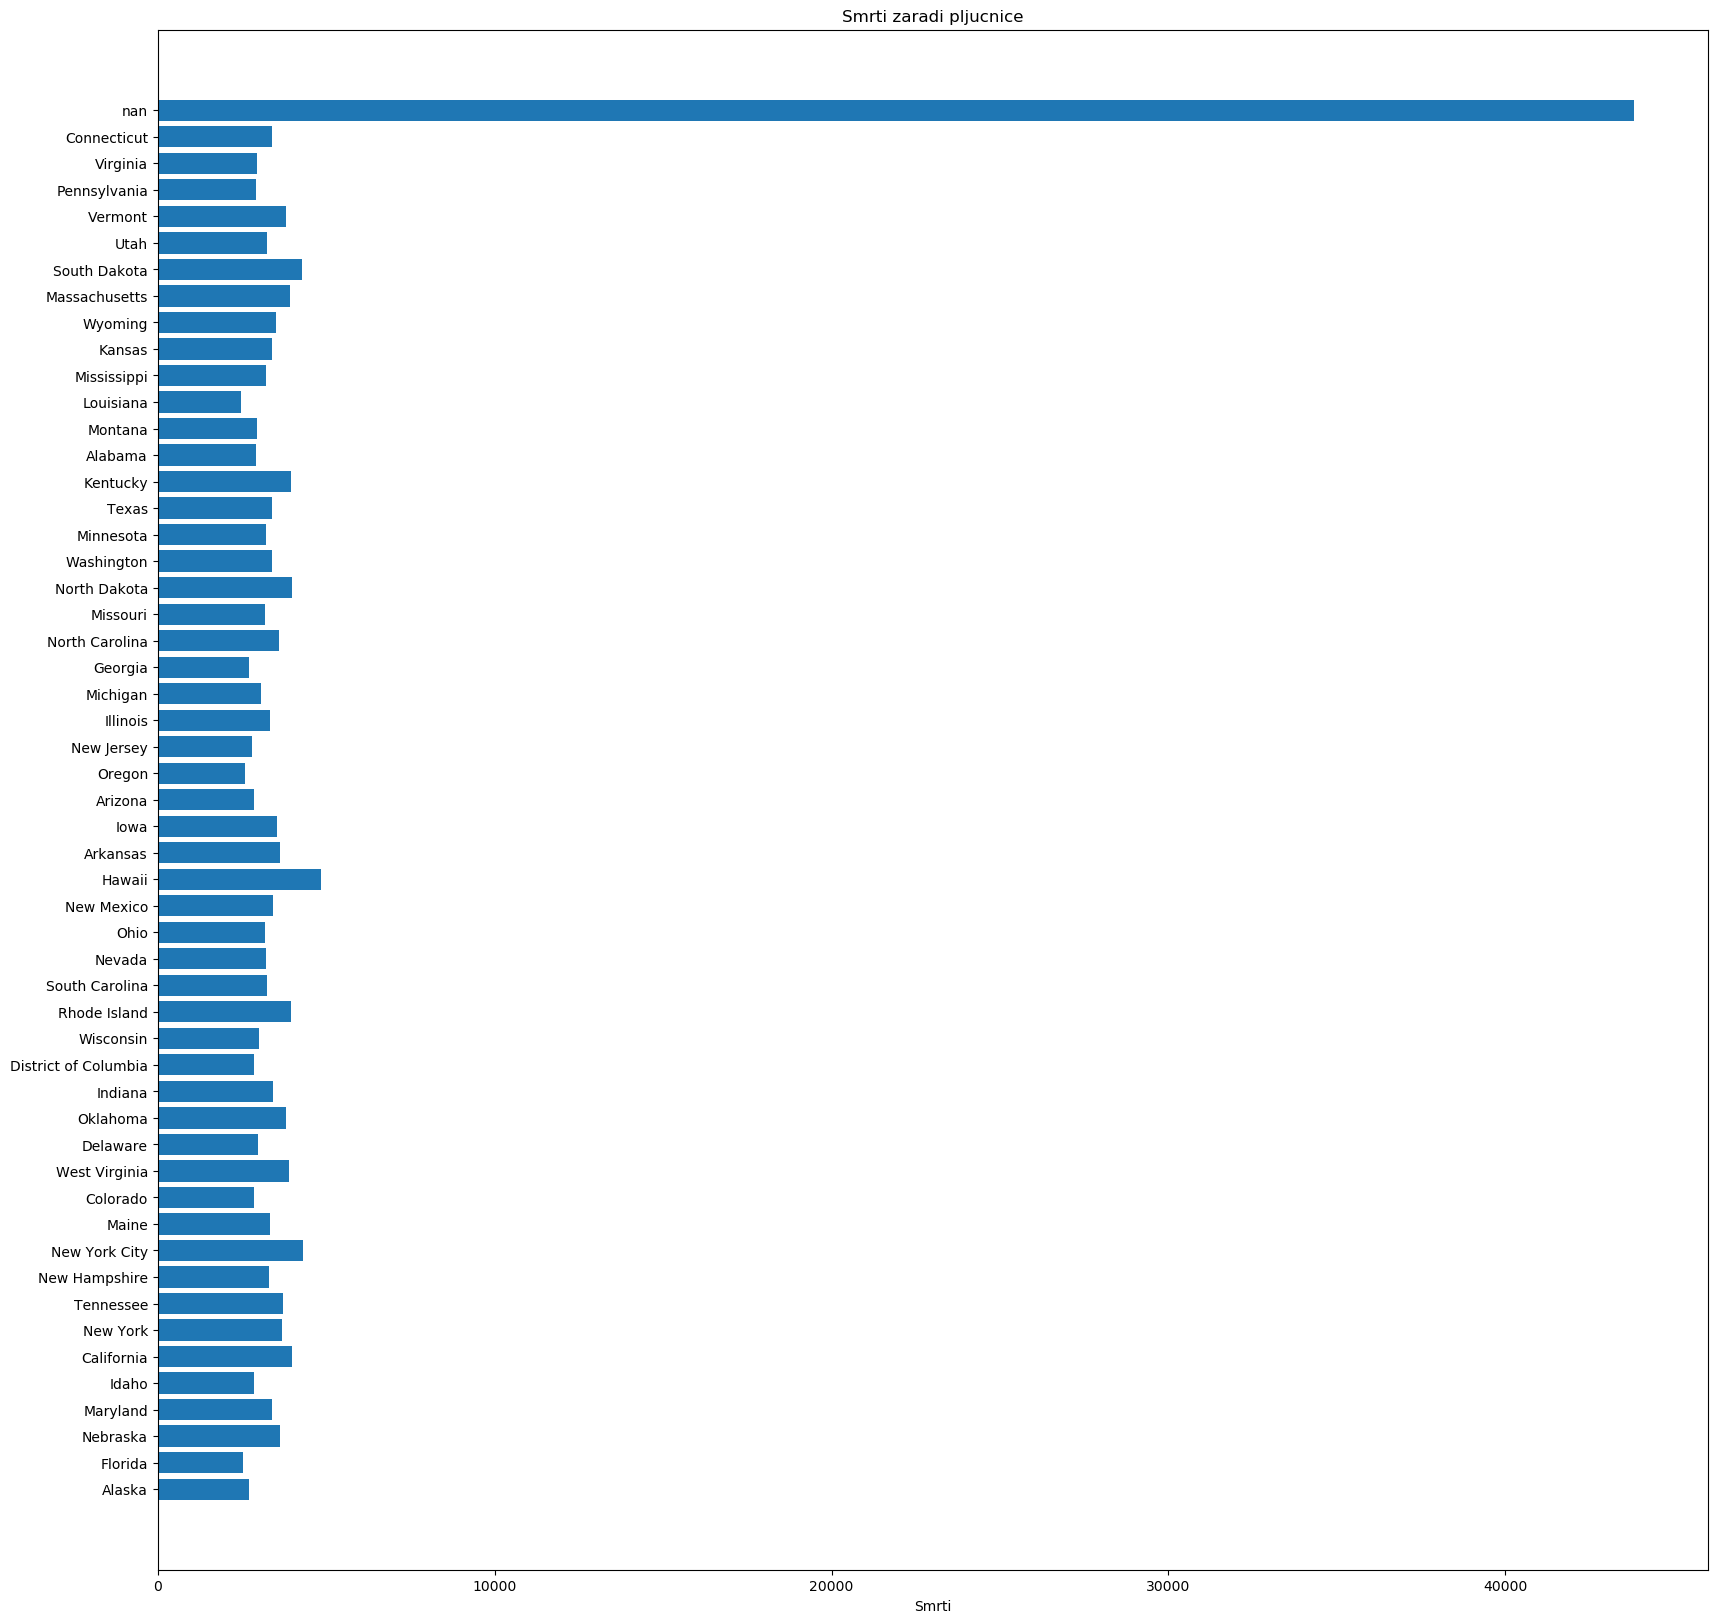

In [200]:
smr_t,smr_gp,smr_pl,smr_g,season,State = read_csv()
leta,dfg,dfp = PripravaZaGripo(season,smr_g,smr_pl)
grp,stejt,vs = PljuvnivaSmrtiDrzava(State,smr_gp,smr_t)    
smrtiZaradiP(stejt,grp)

# Hierarhično gručenje po državah

In [201]:
def Clutr(nmatrix,labels):
    L1 = sch.linkage(nmatrix, method="average", metric="cityblock") 
    t = 0.7
    plt.figure(figsize=(15, 30))
    predictions1 = sch.fcluster(L1, t=t, criterion="distance").ravel()
    D = sch.dendrogram(L1, labels=labels,orientation="left")
    plt.plot([0, 100], [t, t], "k--")
    plt.ylabel("Razdalje")
    plt.show()

Hierarhično gručenje na podatkovni množici, kjer iščemo podobnosti med starostnimi distribucijami med drzavami - gledamo katere države imajo podobno porazdeljeno starost prebivalcev.

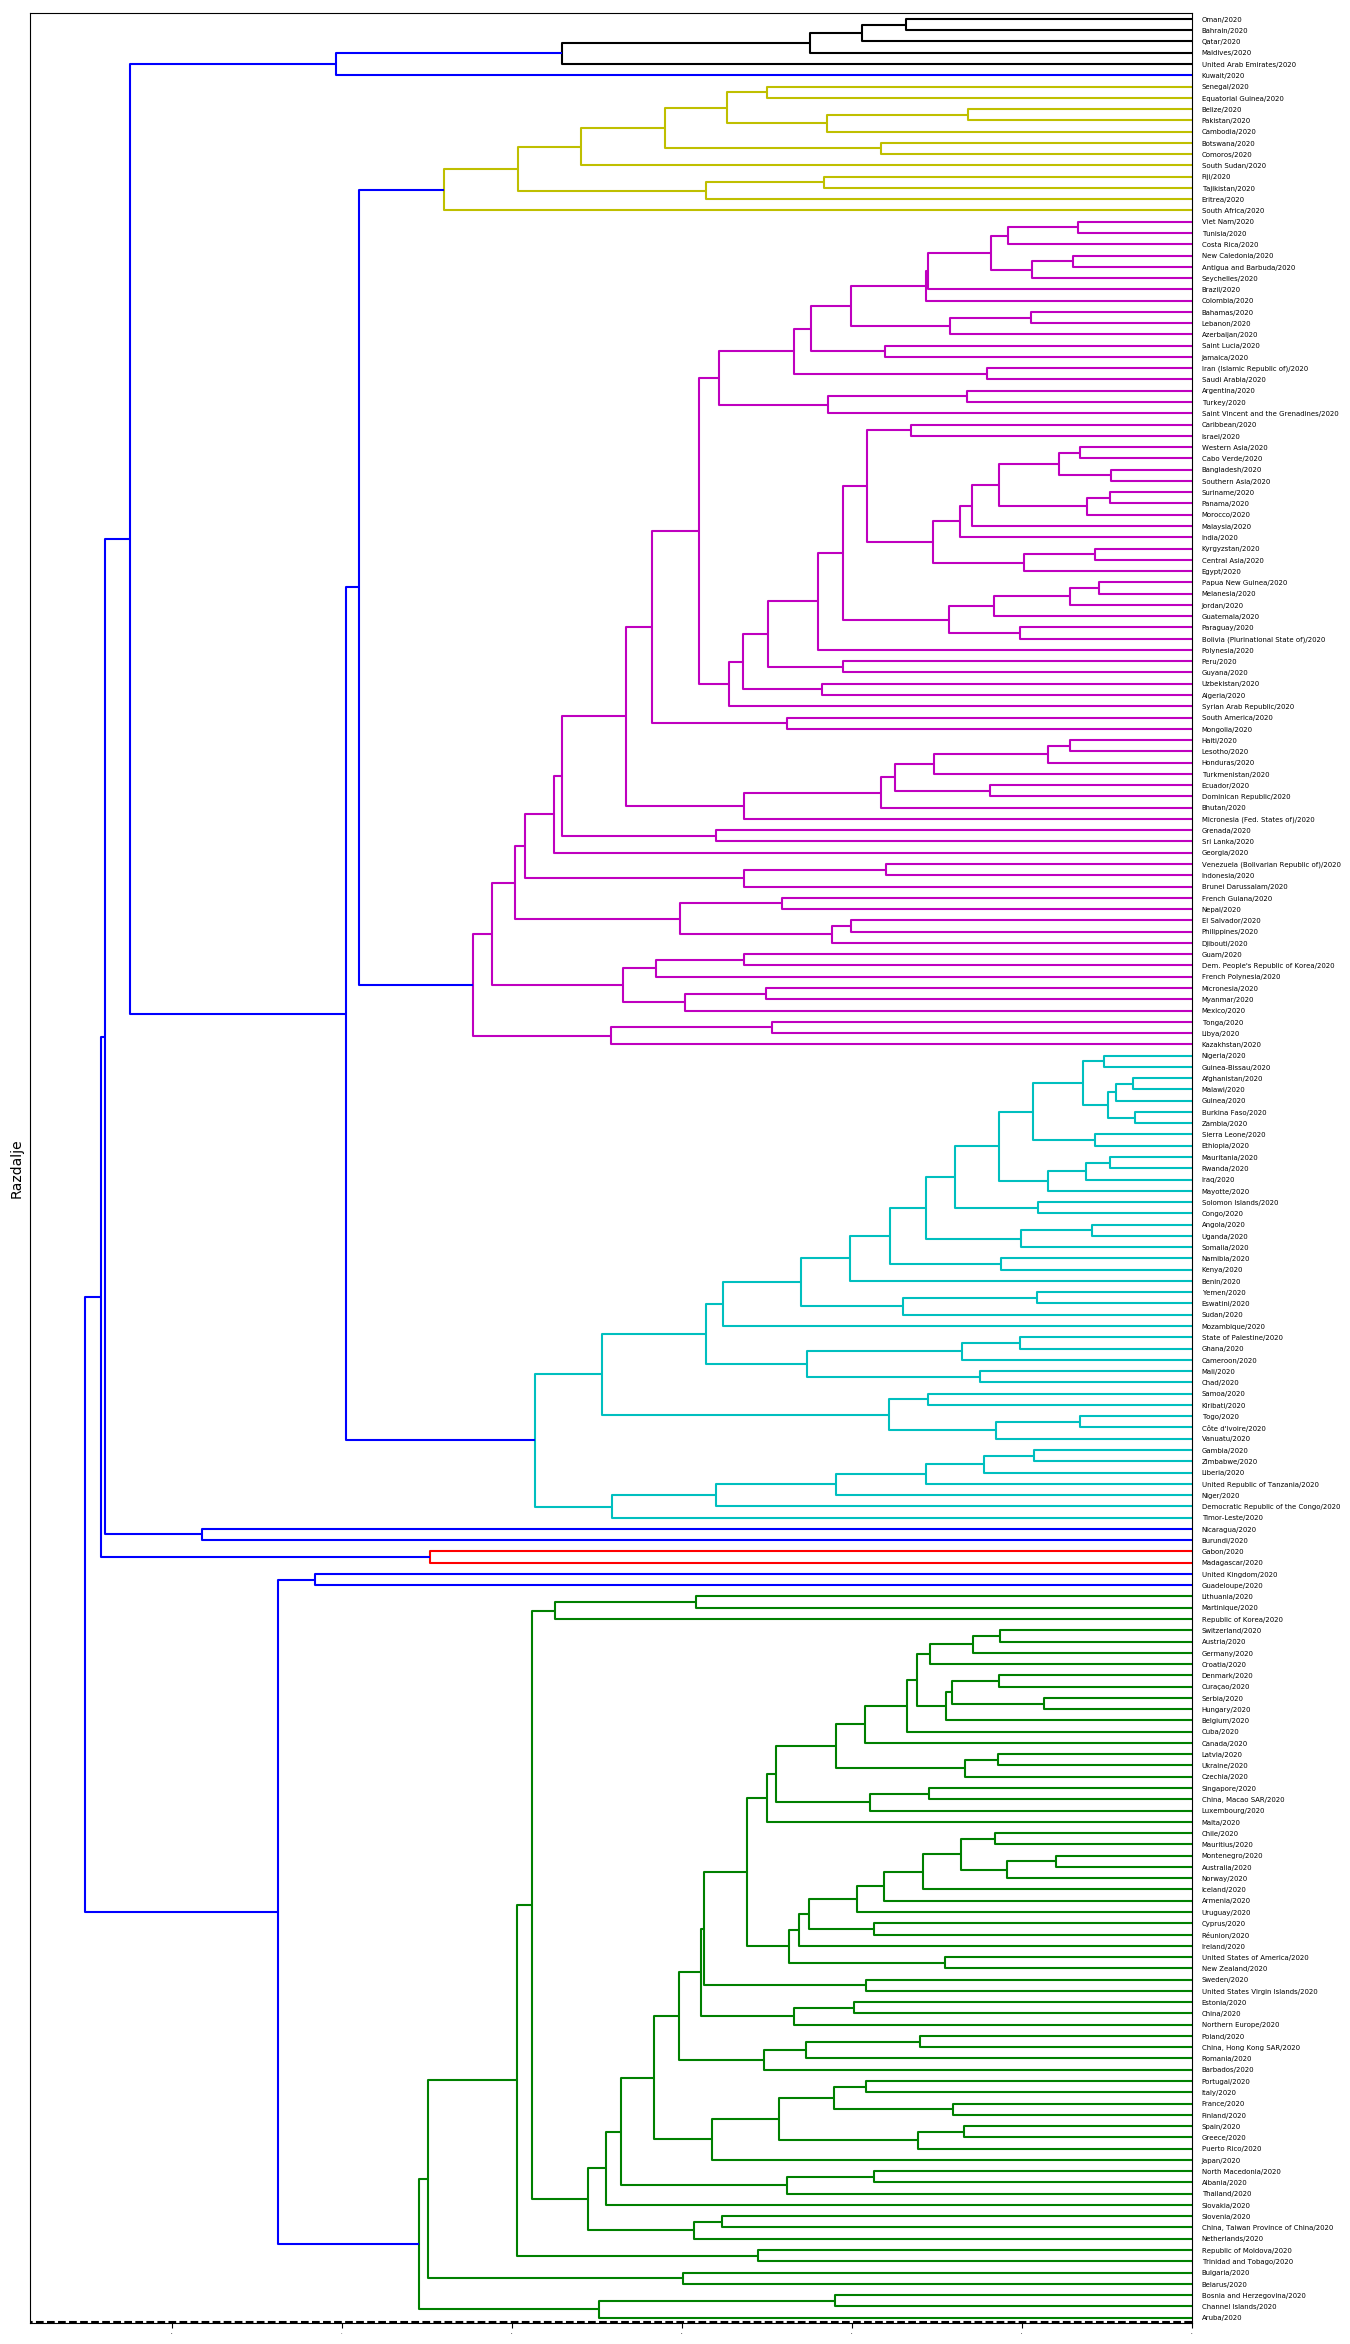

In [202]:
nmatrix,labels =PripravaZaClusteing(main_set)
Clutr(nmatrix,labels)

In [203]:
def DeathUsaCovid():    
    suma1 = 0
    okuzb = 0
    for m in america:
        if int(m[3]) == 2020:
            suma1 += int(m[5])
            okuzb += int(m[4])
    smrti1 = dg
    ns = [suma1 for deathm in range(len(dg))]
    return smrti1,ns,okuzb
def CorgRip(leta,ns,smrti):
    x = np.arange(len(leta))  # the label locations
    width = 0.38  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, ns, width, label='Korona')
    rects2 = ax.bar(x + width/2, smrti1, width, label='Gripa')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    plt.xticks(rotation=45)
    matplotlib.rc('xtick', labelsize=5) 
    ax.set_title('Smrti po letih koronavirus vs gripa')
    ax.set_xticks(x)
    ax.set_xticklabels(leta)
    ax.legend()
    plt.show()

# Smrti zaradi novega COVID-19

OPOMBA: Spodnji graf NE predstavlja covid-19 v danem letu ampak le COVID-19 v letu 2020, v katerem se je tudi pojavil

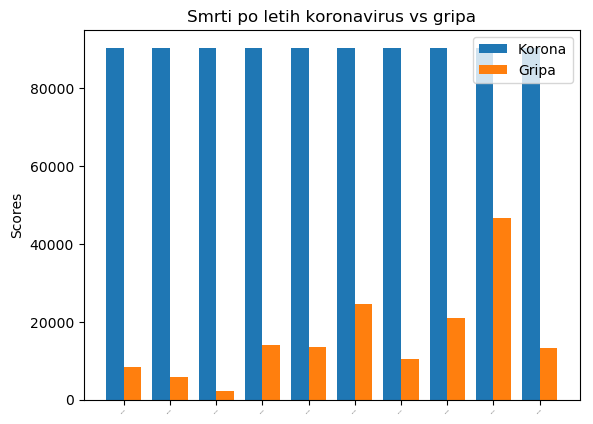

In [204]:

smrti1,ns,okuzb = DeathUsaCovid()
CorgRip(leta,ns,smrti1)

# SMRTNOST ZARADI NOVEGA VIRUSA COVID-19

SMRTNOST PRI NOVEM KOVID-19 V ZDA

In [205]:
TOTAL_D,TOTAL_C,smrtinapreb,smrtnost = PripravaSmrtnosti(matrica)

In [225]:
def printaj(TOTAL_D,TOTAL_C):
    print(f"Skupna smrtnost po vseh drzavah: {TOTAL_D/TOTAL_C*100}%")

In [226]:
printaj(TOTAL_D,TOTAL_C)

Skupna smrtnost po vseh drzavah: 6.7310266724359895%


In [208]:
# Fixing random state for reproducibility
def CoMort(drzave,smrtnosti):
    y_pos = np.arange(len(drzave))
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(60,60))
    ax.barh(y_pos, smrtnosti, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(drzave)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Smrti')
    ax.set_title('Procent mrtvih za coivd')
    plt.show()
def CntRY(drzave,smnapreb):
    y_pos = np.arange(len(drzave))
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(60,60))
    ax.barh(y_pos,  smnapreb, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(drzave)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Smrti')
    ax.set_title('Procent mrtvih za coivd')
    plt.show()    

# Spodnji graf prikazuje, smrtnost zaradi COVID-19 za vsako drzavo

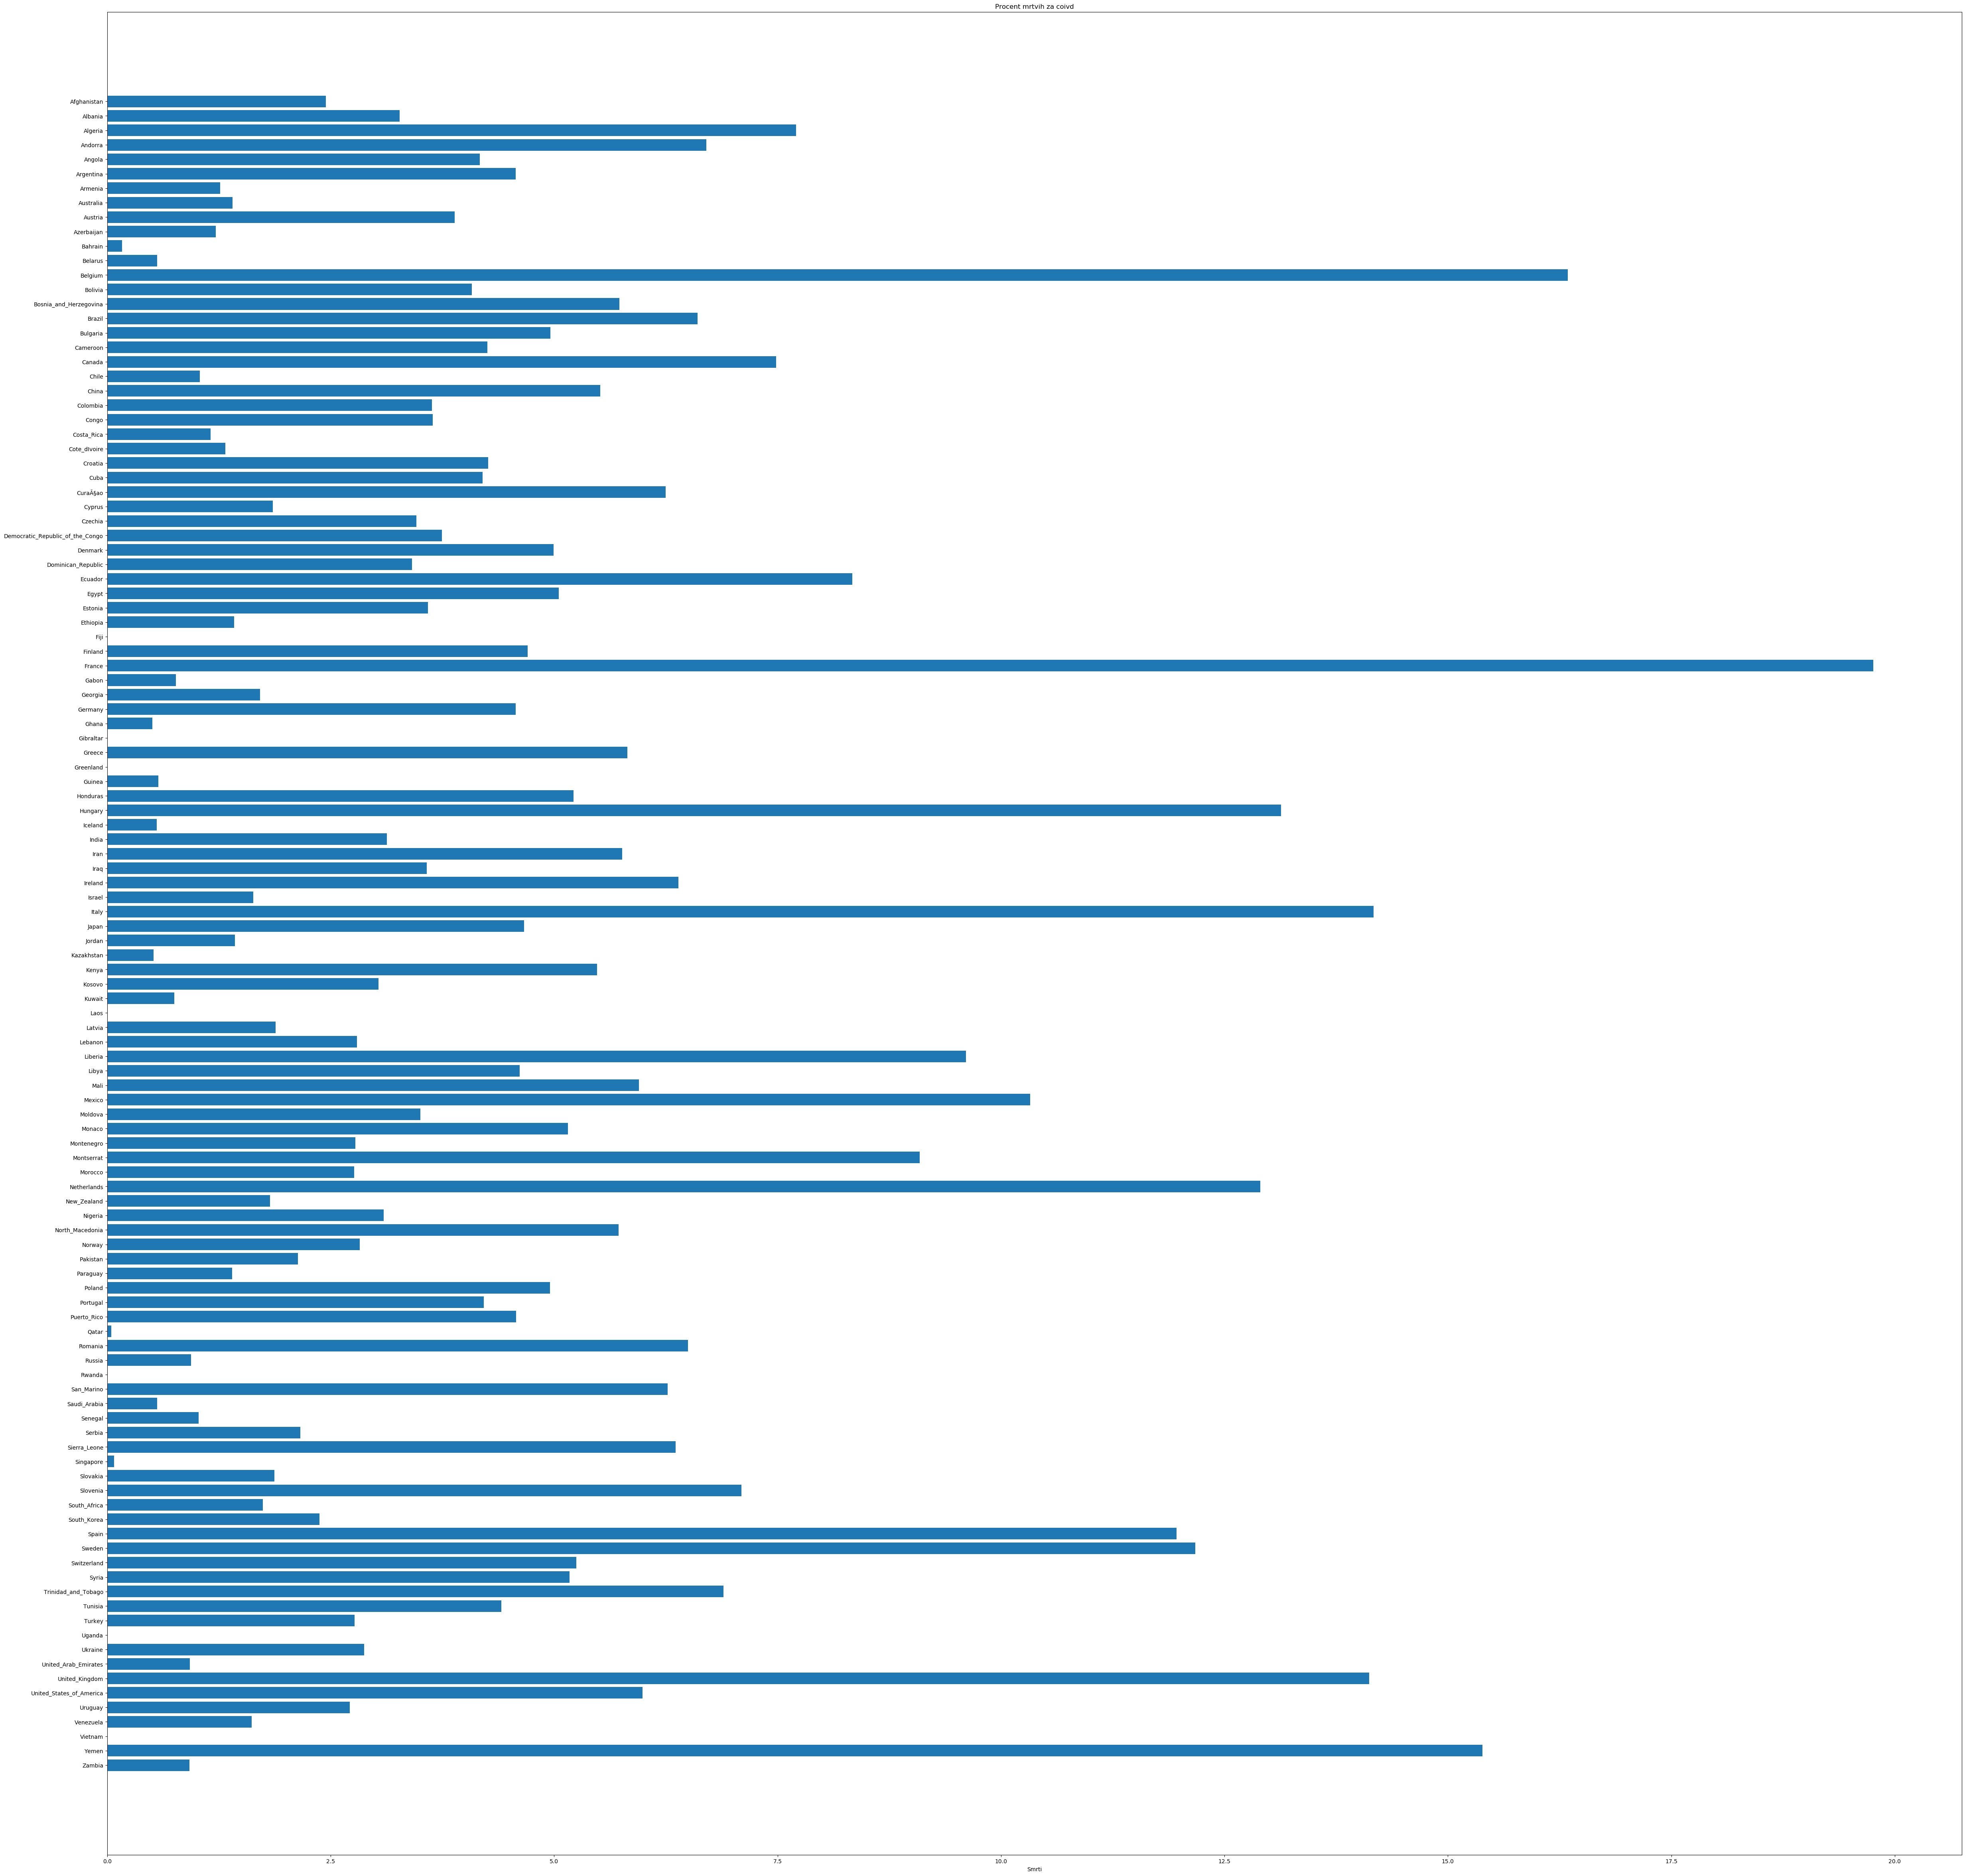

In [209]:
smrtnosti,smnapreb,drzave = PripravaParamSmrt(smrtnost)
CoMort(drzave,smrtnosti)

# Spodnji graf prikazuje, smrti na prebivalca zaradi COVID-19 za vsako drzavo

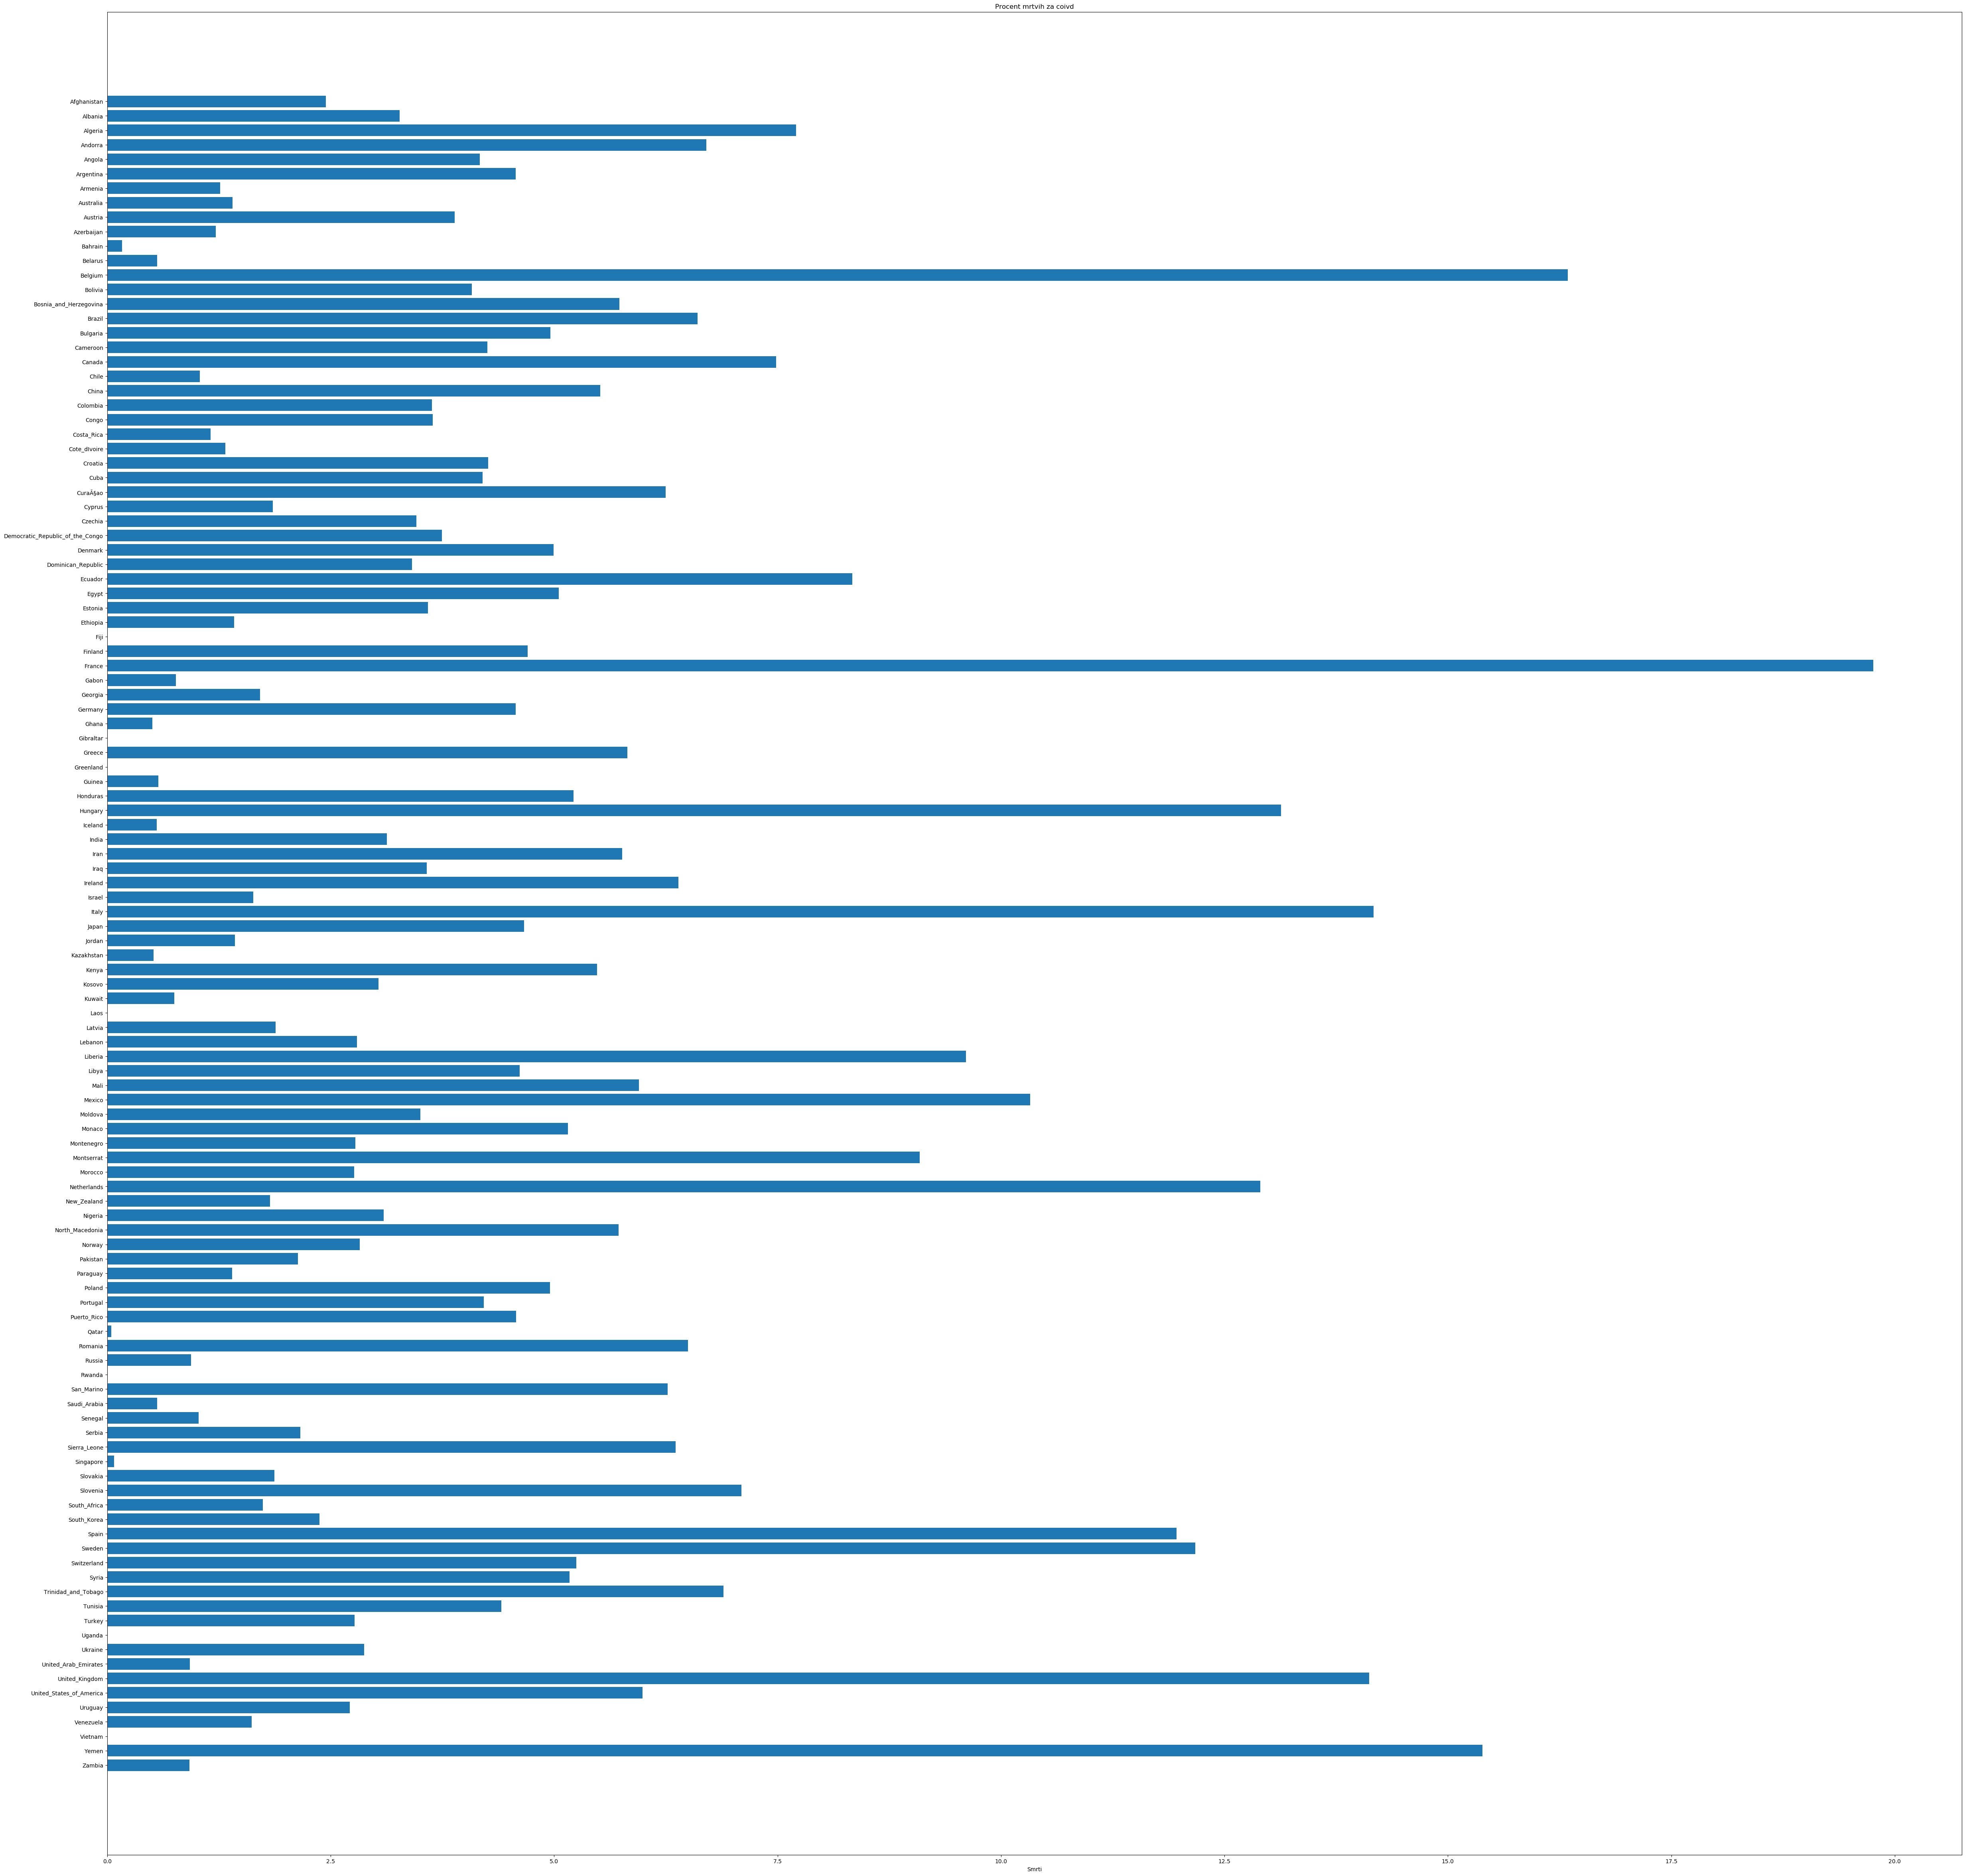

In [210]:
CntRY(drzave,smnapreb)

Poiščimo drave z najvejo smrtnostjo

In [211]:

def Ocena_statistike(smrtnosti):
    data = smrtnosti
    data = [date for date in data]
    # Ocenimo parametre normalne (Gaussove) porazdelitve
    n = len(data)
    mu = np.mean(data)              # ocena sredine
    sigma2 = (n-1)/n * np.var(data) # ocena variance
    return n,mu,sigma2,data

def risi(data):
    plt.figure()
    counts, bins, _ = plt.hist(data, normed=True, label="vzorec", bins=10)    
    pdf = [mvn.pdf(x, mu, sigma2) for x in bins]                              
    plt.plot(bins, pdf, "-", label="model", linewidth=2.0)
    plt.xlabel("povprečna ocena (X)")
    plt.ylabel("P(X)")
    plt.legend(loc=2);

# Kako se smrtnost porazdeli?

Graf, ki prikazuje porazdelitev smrtnosti po državah

C:\Users\Nikolaj\Documents\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


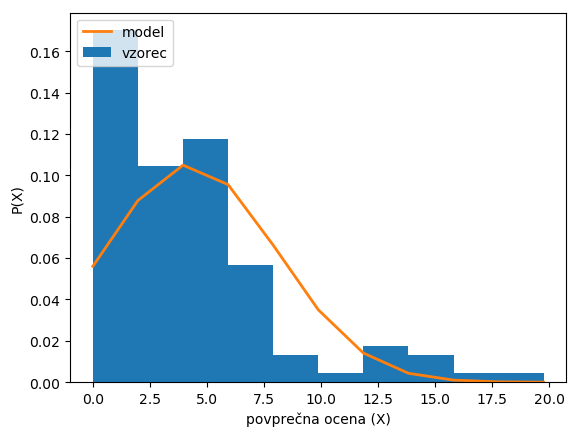

In [212]:
n,mu,sigma2,data = Ocena_statistike(smrtnosti)
risi(data)

In [213]:
def p_val(qx,n,mu,sigma2):
    # Izračunamo P(x) za dovolj velik interval
    xr    = np.linspace(0, 100, 10000)
    width = xr[1] - xr[0]       # sirina intervala
    Px = [mvn.pdf(x, mu, sigma2) * (xr[1]-xr[0])   for x in xr]


    # Vse vrednosti, ki so manjše ali enake od qx
    ltx     = xr[xr <= qx]      

    # Množimo s širino intervala, da dobimo ploščino pod krivuljo
    P_ltx = [mvn.pdf(x, mu, sigma2) * width for x in ltx] 

    # p-vrednost: ploscina pod krivuljo P(x) za vse vrednosti, manjse od qx
    p_value = np.sum(P_ltx)

    # Graf funkcije
   
    return p_value

In [214]:
def Dobre(smrtnost,n,mu,sigma2):
    alpha = 0.05
    for drzave,smrti in smrtnost.items():
        if p_val(smrti,n,mu,sigma2) < alpha:
            print(drzave)


# Države z nizko smrtnostjo zaradi COVID-19

In [ ]:
Spodnji seznam predstavlja države, katere pašejo v najnizji 5% statistično značilnih držav, glede na stopnjo smrtnosti

In [215]:
Dobre(smrtnost,n,mu,sigma2)

Anguilla
Bahrain
Belarus
Benin
Bhutan
Bonaire, Saint Eustatius and Saba
Brunei_Darussalam
Cambodia
Central_African_Republic
Djibouti
Dominica
Eritrea
Falkland_Islands_(Malvinas)
Faroe_Islands
Fiji
French_Polynesia
Gabon
Ghana
Gibraltar
Greenland
Grenada
Guinea
Guinea_Bissau
Holy_See
Iceland
Kazakhstan
Kuwait
Laos
Lesotho
Madagascar
Maldives
Mongolia
Mozambique
Namibia
Nepal
New_Caledonia
Oman
Palestine
Papua_New_Guinea
Qatar
Rwanda
Saint_Kitts_and_Nevis
Saint_Lucia
Saint_Vincent_and_the_Grenadines
Saudi_Arabia
Seychelles
Singapore
Timor_Leste
Uganda
Uzbekistan
Vietnam
Western_Sahara


In [216]:
def Slabe(smrtnost,n,mu,sigma2):
    alpha = 0.85
    for drzave,smrti in smrtnost.items():
        if p_val(smrti,n,mu,sigma2) > alpha:
            print(drzave)

# # Države z visoko smrtnostjo zaradi COVID-19

Spodnji seznam predstavlja države, katere pašejo v najvišjih 15% statistično značilnih držav, glede na stopnjo smrtnosti

In [217]:
Slabe(smrtnost,n,mu,sigma2)

Belgium
British_Virgin_Islands
France
Hungary
Italy
Netherlands
Nicaragua
Sint_Maarten
Sweden
United_Kingdom
Yemen


# Zaključek za smrtnost:

Pri hierarhičnem gručenju, smo opazili več skupin, katere imajo sorodno starostno distribucijo. Skupine smiselno sovpadajo z realnim svetom na ta način, da imamo naprimer črno skupino v kateri so ZAE ,Qatar,Bahrain, Maldivi, Oman in zanje lahko tudi v realnem svetu prepoznamo podobnosti v kulturi, načinu življenja, ekonsomskem stanju(viri nafte...) in tudi starostni porazdelitvi(precejšen del je mlajše generacije), dobimo zeleno gručo z večino evropskih držav, modro z pretežno afriškimi državami, temno modro z UK(smo že drugje opazili da deluje kot osamelec, ko smo pripravljali to gručenje) in nekaj sorodnimi državami, vijolično skupino z pretežno latinskimi državami in otoki, rumeno skupino ter rdečo skupino, ki je osamelec saj ima bistveno manj predstavnikov, in je težko opredelimo na določeno etnično ali geografsko območje. Rumena skupina določa določene dele afrike med njimi tudi nekatere razvitejše(South africa). Kako to upliva na smrti zaradi COVID? Črna skupina se naprimer z izjemo ZAE uvršča v spodnjih 5% po stevilu smrti zaradi pojava novega koronairusa, kar je zelo vrjetno posledica pomembnega atributa karkšen je starostna distribucija. Za omenjene države trdimo, da imajo pretežno mlade prebivalce za katere je virus bistveno manj nevaren kakor naprimer za države, z večjim deležem ljdui 100+,90+ itd. Države iz zelene skupine, kakor Italija, Belorusija, Francija so se uvrstile v precej večjem številu v skupino statstično najbolj značilnih držav(pri njih je stopnja smrtnosti največja), nekatere države so se kljub temu uvrstile v spodnji predel. Na to so najbolj verjetno močno uplivali dejavniki, kot so ukrepi (Njihova struktura za pomembnejša območja je opisana v drugem razdelku). Poleg tega je očitno pomembna tudi socialno-ekonomska situacija(revne afriške države se hitreje razmnožujejo in prej umirajo zaradi nižjega standarda), bogate države z specifično kulturo se klasificirajo drugam kakor klasični razviti svet ali afrika. 